# Load Data

In [1]:
using GeophysicalFlows, Random, Printf, Plots, JLD2, Statistics, CUDA, FFTW
using LinearAlgebra: mul!, ldiv!
parsevalsum = FourierFlows.parsevalsum

dev = CPU()     # Device (CPU/GPU)

# ## Numerical, domain, and simulation parameters

 n, L  = 512, 2π              # grid resolution and domain length
 ν, nν = 0.01, 1             # viscosity coefficient and hyperviscosity order
 μ, nμ = 0.1, 0              # linear drag coefficient
    dt = 0.0002                # timestep
nsteps = 20000             # total number of steps
 nsubs = 100                 # number of steps between each plot


grid = TwoDGrid(dev; nx=n, Lx=L)
K = @. sqrt(grid.Krsq)    # a 2D array with the total wavenumber

x, y = grid.x, grid.y

nothing # hide

In [2]:
data = jldopen("/storage/p2/parfenyev/2d_turbulence/pinn/get_data/alpha_0.1/alpha_01_v2.jld2")

nothing # hide

## Visualizing the vorticity

In [3]:
Num = 200 # Number of snapshots under analysis

vort_h = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]
vort = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]

for i in 1:Num
    number = i*nsubs
    name = "snapshots/sol/"*string(number)
    vort_h[i] = data[name] # Завихренность в k-пространстве
    ldiv!(vort[i], grid.rfftplan, deepcopy(vort_h[i])) # Завихренность в x-пространстве
end

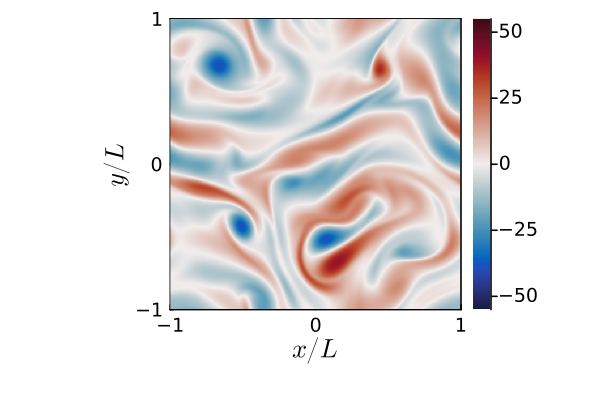

In [18]:
using LaTeXStrings

p = heatmap(2*x/L, 2*y/L, Array(vort[70]'),
         aspectratio = 1,
                   c = :balance,
                clim = (-55, 55),
               xlims = (-1, 1),
               ylims = (-1, 1),
              xticks = -3:3,
              yticks = -3:3,
              xlabel = L"x/L",
              ylabel = L"y/L",
          framestyle = :box, thickness_scaling=1.6, legend=true)

#savefig(p, "./vort.svg")

# Total Energy

In [27]:
using Statistics

energy_h = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]
Ehr = [ Matrix{ComplexF64}(undef, Int(n),1) for _ in 1:Num ]
energy = zeros(Num)

E_av_rad = zeros(Int(n),1)

for i in 1:Num
    @. energy_h[i] = 1 / 2 * grid.invKrsq * abs2(vort_h[i])
    energy[i] = 1 / (grid.Lx * grid.Ly) * parsevalsum(energy_h[i], grid)
    
    kr, Ehr[i] = FourierFlows.radialspectrum(energy_h[i]/(grid.Lx * grid.Ly), grid, refinement=1)
    E_av_rad+=abs.(Ehr[i])/Num
end

mean(energy)

8.766941370133386

In [28]:
minimum(energy)

8.531523616879264

In [29]:
maximum(energy)

9.042326239092642

# Video

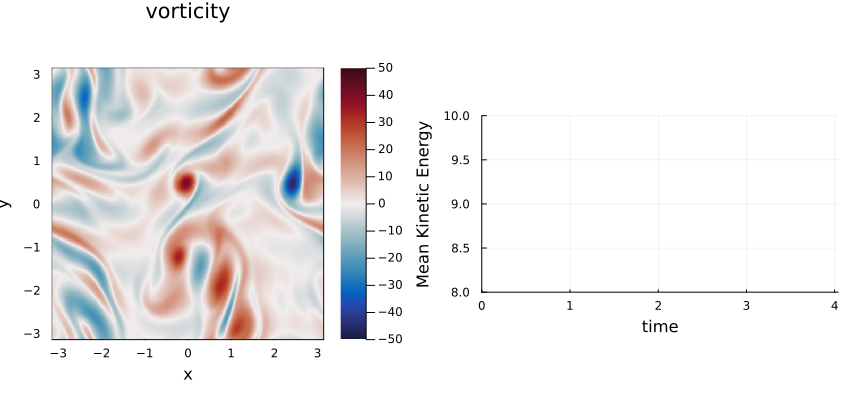

In [10]:
p1 = heatmap(x, y, Array(vort[1]'),
         aspectratio = 1,
                   c = :balance,
                clim = (-50, 50),
               xlims = (-L/2, L/2),
               ylims = (-L/2, L/2),
              xticks = -3:3,
              yticks = -3:3,
              xlabel = "x",
              ylabel = "y",
               title = "vorticity",
          framestyle = :box)

p2 = plot(1, # this means "a plot with two series"
               ylabel = "Mean Kinetic Energy",
              legend = false,
           linewidth = 2,
               alpha = 0.7,
              xlabel = "time",
               xlims = (0, 1.01 * Num * nsubs * dt),
               ylims = (8.0, 10.0),
         aspectratio = 1)

#l = @layout Plots.grid(1, 2)
p = plot(p1, p2, layout = (1,2), size = (850, 420))

In [11]:
anim = @animate for j = 1:Num
  p[1][1][:z] = Array(vort[j])
  p[1][:title] = "vorticity, t = " * @sprintf("%.2f", j*dt*nsubs)
  push!(p[2][1], j*dt*nsubs, energy[j])
end

mp4(anim, "video.mp4", fps=18)

[ Info: Saved animation to /home/students/parfeniev/!numeric/2d_turbulence/pinn/get_data/alpha_0.1/video.mp4


Plots.AnimatedGif("/home/students/parfeniev/!numeric/2d_turbulence/pinn/get_data/alpha_0.1/video.mp4")

# Energy Spectrum

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106


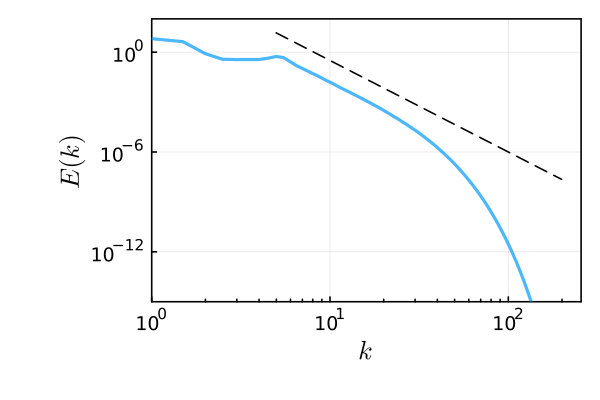

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106


In [61]:
kr, Ehr[1] = FourierFlows.radialspectrum(energy_h[1]/(grid.Lx * grid.Ly), grid, refinement=1)
norm = grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2) # нормировка для Фурье из суммы Парсевалля

plot(kr, E_av_rad*norm, thickness_scaling=1.6,
    linewidth = 2,
        alpha = 0.7,
       xlabel = L"k", ylabel = L"E(k)",
        xlims = (1, grid.nx/2), xminorticks=9,
        ylims = (1e-15,1e2), yticks=[1e-12, 1e-6, 1],
       xscale = :log10, yscale = :log10,
       label = false,
   framestyle = :box)

plt = plot!(kr[11:400], 1e5*kr[11:400].^(-5.5), label=false, ls=:dash, color=:black)
#savefig(plt, "./spectr.svg")

In [13]:
vort_to_save = zeros(200, 512, 512) 

for i in 1:200
    vort_to_save[i,:,:]=vort[i]
end

In [14]:
using HDF5

h5write("./vort-prod.h5", "vorticity", vort_to_save)

# Velocity field

In [15]:
uh = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ] # Фурье от u 
vh = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ] # Фурье от v
u = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]
v = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]

for i in 1:Num
    @. uh[i] =   im * grid.l  * grid.invKrsq * vort_h[i]
    @. vh[i] = - im * grid.kr * grid.invKrsq * vort_h[i]
    ldiv!(u[i], grid.rfftplan, deepcopy(uh[i])) # Обратное Фурье
    ldiv!(v[i], grid.rfftplan, deepcopy(vh[i])) # Обратное Фурье
end

In [16]:
u_to_save = zeros(Num, 512, 512) 
v_to_save = zeros(Num, 512, 512)

for i in 1:Num
    u_to_save[i,:,:]=u[i]
    v_to_save[i,:,:]=v[i]
end

In [17]:
using HDF5

h5write("./vel-u-prod.h5", "vel-u", u_to_save)
h5write("./vel-v-prod.h5", "vel-v", v_to_save)

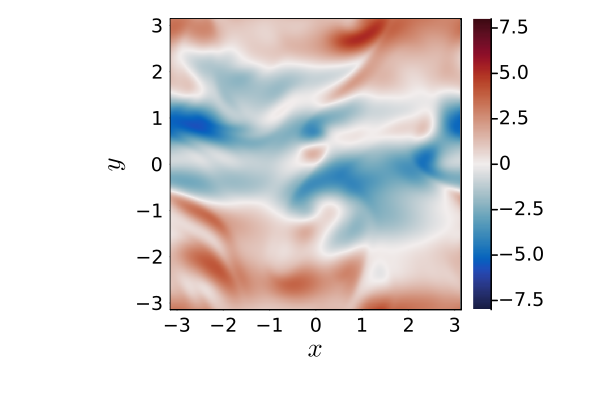

In [18]:
using LaTeXStrings

p = heatmap(x, y, Array(u[1]'),
         aspectratio = 1,
                   c = :balance,
                clim = (-8, 8),
               xlims = (-L/2, L/2),
               ylims = (-L/2, L/2),
              xticks = -3:3,
              yticks = -3:3,
              xlabel = L"x",
              ylabel = L"y",
          framestyle = :box, thickness_scaling=1.6, legend=true)

#savefig(p, "./u.svg")

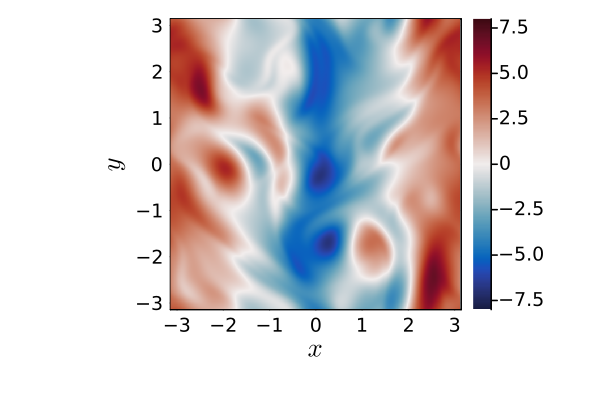

In [19]:
using LaTeXStrings

p = heatmap(x, y, Array(v[200]'),
         aspectratio = 1,
                   c = :balance,
                clim = (-8, 8),
               xlims = (-L/2, L/2),
               ylims = (-L/2, L/2),
              xticks = -3:3,
              yticks = -3:3,
              xlabel = L"x",
              ylabel = L"y",
          framestyle = :box, thickness_scaling=1.6, legend=true)

#savefig(p, "./v.svg")

# Pressure Field

In [20]:
dx_uh = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]
dx_vh = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]
dy_uh = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]
p_h = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]
rhs_h = [ Matrix{ComplexF64}(undef,Int(n/2+1),Int(n)) for _ in 1:Num ]

dx_u = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]
dx_v = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]
dy_u = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]
rhs = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]
p = [ Matrix{Float64}(undef,Int(n),Int(n)) for _ in 1:Num ]

for i in 1:Num
    @. dx_uh[i] =   im * grid.kr  * uh[i]
    @. dx_vh[i] =   im * grid.kr  * vh[i]
    @. dy_uh[i] =   im * grid.l  * uh[i]    
    ldiv!(dx_u[i], grid.rfftplan, deepcopy(dx_uh[i]))
    ldiv!(dx_v[i], grid.rfftplan, deepcopy(dx_vh[i]))
    ldiv!(dy_u[i], grid.rfftplan, deepcopy(dy_uh[i]))
    
    @. rhs[i] = 2*dx_u[i]^2 + 2*dx_v[i]*dy_u[i]
    mul!(rhs_h[i], grid.rfftplan, deepcopy(rhs[i]))
    
    @. p_h[i] = grid.invKrsq * rhs_h[i]
    ldiv!(p[i], grid.rfftplan, deepcopy(p_h[i]))
end

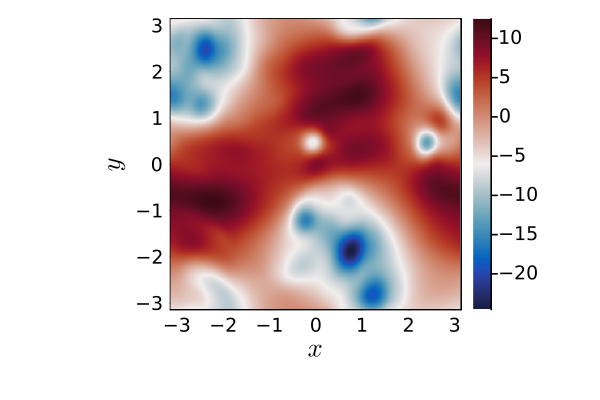

In [21]:
using LaTeXStrings

heatmap(x, y, Array(p[1]'),
         aspectratio = 1,
                   c = :balance,
                #clim = (-8, 8),
               xlims = (-L/2, L/2),
               ylims = (-L/2, L/2),
              xticks = -3:3,
              yticks = -3:3,
              xlabel = L"x",
              ylabel = L"y",
          framestyle = :box, thickness_scaling=1.6, legend=true)

In [22]:
p_to_save = zeros(Num, 512, 512) 

for i in 1:Num
    p_to_save[i,:,:]=p[i]
end

In [23]:
using HDF5

h5write("./p-prod.h5", "p", p_to_save)